# Analysis 1-2

In [ ]:
// %load src/scala/spark_imports.scala

In [ ]:
import org.apache.spark.sql._
import org.apache.spark.sql.functions._
import org.apache.spark.sql.types._
import spark.implicits._

## Load experiment 1-part1 data with spark

In [ ]:
val healthy_prescriptions = spark
    .read
    .parquet("spark-warehouse/experiment1-data/healthy/4L_prescriptions/")
healthy_prescriptions.createOrReplaceTempView("e1_healthy_pres")
val hosp_prescriptions = spark
    .read
    .parquet("spark-warehouse/experiment1-data/hospitalized/4L_prescriptions/")
hosp_prescriptions.createOrReplaceTempView("e1_hosp_pres")
val hosp_hospitalizations = spark
    .read
    .parquet("spark-warehouse/experiment1-data/hospitalized/hospitalizations/")
hosp_hospitalizations.createOrReplaceTempView("e1_hosp_hospitalizations")

In [ ]:
healthy_prescriptions.drop("id").show(2)
hosp_prescriptions.drop("id").show(2)
hosp_hospitalizations.drop("id").show(2)
spark.sql("show tables").show()

## Now we have the data in python in a manageable format
Further we need to: 
* Encode drugs
    * First attempt will be to one-hot encode the drugs
        * There are ~1200 drugs in the set, reduced to ~250 (or so) by taking 4 levels of the ATC system.
        * Thus we need some feature selection
        
* Encode dates
    * Can perform random sampling of N days for healthy population (with constraint such as at least one prescription)
    * For hospitalized population we must pick some window of the same N days but with no hospitalizations during said days
    
___

### One idea for the drug selection
* We may want to apply a constraint for feature inclusion. For example we may require that a drug must be prescribed to a minimum of N patients for it to be included in the data.

In [ ]:
%%python
healthy_pres = spark.sql("select * from e1_healthy_pres").groupBy("4l_atccode").count()
healthy_pres.printSchema()

hosp_pres = spark.sql("select * from e1_hosp_pres").groupBy("4l_atccode").count()
hosp_pres.printSchema()

### Compute the overlap of prescriptions between the two datasets
* For our subset of 10.000 patients we observe approximately 30 L-4 ATC groups being exclusively prescribed to each group of patients. We eliminate these drugs

In [ ]:
%%python
drugs1 = healthy_pres.select("4l_atccode", "count").withColumnRenamed("4l_atccode", "atc_4l_1")\
    .withColumnRenamed("count","count_healthy").distinct()
drugs2 = hosp_pres.select("4l_atccode", "count").withColumnRenamed("4l_atccode","atc_4l_2")\
    .withColumnRenamed("count","count_hospitalized").distinct()
print("number of L4-drugs in healthy population: ",drugs1.count())
print("number of L4-drugs in hospitalized population: ",drugs2.count())

drugs_in_both = drugs1.join(drugs2, drugs1.atc_4l_1==drugs2.atc_4l_2).distinct() \
    .select("atc_4l_1", "count_healthy","count_hospitalized").withColumnRenamed("atc_4l_1","atc_4l").sort("atc_4l")
#drugs_in_both.show()
print()

print("Drugs in both populations:", drugs_in_both.count())
drugs_in_both.show(10)

alldrugs_array = drugs_in_both.select("atc_4l").toPandas().values.reshape(-1)
alldrugs_array = alldrugs_array.reshape((alldrugs_array.shape[0], 1))

## We use Sklearn's MultiLabelBinarizer to encode the drugs into a vector format

In [ ]:
%%python 
import sklearn.preprocessing
import numpy as np
import pandas as pd
# Encoder outputs a sparse matrix unless sparse=False is set on init
encoder = sklearn.preprocessing.MultiLabelBinarizer()
# fit_transform creates a vector representation (a one-hot encoding) 
# based on the values we provide it
y_indicator = encoder.fit_transform(alldrugs_array)
n_classes = y_indicator.shape[1]

#### Testing that we can use the multilabel binarizer inversely to output the drug codes

In [ ]:
%%python
# This is an example of what a single hospitalized patient's input could look like
dat = np.array([["A02AC", "A02BB"], ["A02BX", "A05AA","A07DA"]])
print("Encoded sample with two drug codes outputs a binary vector with two ones in it")
print(encoder.transform(dat))

# Diagonal matrix with some values ticked
inv_dat = np.zeros(shape=(36,n_classes))
diagonal = np.eye(35) #should display only the first 35 drugs
inv_dat[0:diagonal.shape[0],0:diagonal.shape[1]] = diagonal

print("\nEncoded diagonal matrix")
print(encoder.inverse_transform(inv_dat)[:50])

### Example with multiple labels set to 1
* Inverse transform Returns a list of drugs per input

In [9]:
%%python
inputvector = np.zeros((3, n_classes))
inputvector[ 0, 35:37 ] = 1.0
inputvector[1, 45:49] = 1.0
inputvector[2, 300:303] = 1.0
print(encoder.inverse_transform(inputvector))

# Bucketing drug consumption of relevant time windows and binarizing them
* By bucketing drugs into windows of time (a list per 'time window') we should be able to binarize them directly into vectors useful for classifier training

In [10]:
spark.sql("show tables").show(false)

### Implementing bucketing for a single patient
* Take a random patient from the hosp_pres data set
* gather all of said patient's hospitalizations from the hospitalization dataset

In [11]:
%%python 
from pyspark.sql.functions import col

ids_from_pres_count = spark.sql("SELECT id FROM e1_hosp_pres").distinct().sort(col("id").asc()).count()
ids_from_hosp_count = spark.sql("SELECT id from e1_hosp_hospitalizations").distinct().sort(col("id").asc()).count()
print( ids_from_pres_count,", ", ids_from_hosp_count ) 

* Let's first see if we can find the longest N windows per patient
* Note that the following code block groups the hospitalizations by ID, then applies a collection aggregate
    * This yields a list of hospitalizations per patient

In [16]:
%%python
from pyspark.sql.functions import collect_list, struct
spark_hospitalization_list = spark.sql("""select * from e1_hosp_hospitalizations""")\
    .groupBy("id")\
    .agg(collect_list(struct("diffdager_inn", "diffdager_ut")))

col_labels = spark_hospitalization_list.schema.names

spark_hospitalization_list = spark_hospitalization_list.select(col(col_labels[0]),col(col_labels[1]).alias("hospitalization_list"))

singleListOfHospitalizations = spark_hospitalization_list.toPandas()


In [17]:
%%python
lhosp = singleListOfHospitalizations
sorter = lambda l: sorted(l, key=lambda tup: tup[1])
lhosp[lhosp.columns[1]] = lhosp[lhosp.columns[1]].apply(sorter)
print("Sorted list of hospitalizations per patient: ")
print(lhosp[:10]["hospitalization_list"])

Sorted list of hospitalizations per patient: 
0    [(-124, -124), (-57, -57), (0, 6), (20, 20), (...
1     [(0, 8), (35, 35), (44, 44), (49, 53), (95, 95)]
2                                 [(0, 1), (133, 133)]
3                 [(-154, -154), (-154, -154), (0, 1)]
4    [(-293, -293), (-174, -174), (-119, -119), (-7...
5    [(-325, -325), (0, 1), (32, 32), (123, 123), (...
6    [(-352, -352), (-249, -249), (-202, -202), (-2...
7        [(-354, -354), (-125, -123), (0, 1), (4, 12)]
8    [(-196, -193), (0, 4), (13, 22), (23, 24), (24...
9        [(-341, -338), (-221, -221), (0, 7), (9, 13)]
Name: hospitalization_list, dtype: object


### We may now implement two different methods of computing the importance of the different time windows
* A function which outputs in descending order the longest windows of time between hospitalizations per patient
* A function which outputs the total number of prescriptions in each window between hospitalizations

In [48]:
%%python
# Return start and end-time of window without hospitalizations
def get_n_longest_windows(hosp_list, n=2):
    # if the number of hospitalizations is 1, output the window as 30 days prior to datediff 0
    if len(hosp_list) == 1:
        return [[30, -31, -1]]
    
    windows = []
    i=0
    while i<(len(hosp_list) - 1):
        start = hosp_list[i][1]
        end = hosp_list[i+1][0]
        curr_window_len = end-start
        if curr_window_len > 30*2:
            windows.append([curr_window_len, start, end])
        i+=1
    return sorted(windows, key=lambda x: x[0], reverse=True)[:n]

In [49]:
%%python
# Test the functions
windows_before_filter = (lhosp[lhosp.columns[1]].map(lambda x: get_n_longest_windows(x, n=3)))
windows = windows_before_filter
#windows = windows_before_filter[list(map(lambda x: len(x)>0, windows_before_filter))]
print(windows[:10])

0                    [[198, 20, 218], [67, -124, -57]]
1                                                   []
2                                      [[132, 1, 133]]
3                                     [[154, -154, 0]]
4                    [[119, -293, -174], [70, -70, 0]]
5      [[325, -325, 0], [91, 32, 123], [63, 123, 186]]
6    [[182, 1, 183], [149, -202, -53], [103, -352, ...
7                  [[229, -354, -125], [123, -123, 0]]
8                                     [[193, -193, 0]]
9                  [[221, -221, 0], [117, -338, -221]]
Name: hospitalization_list, dtype: object


In [50]:
%%python
import os
print(os.environ["PYSPARK_PYTHON"])

python3


In [ ]:
%%python
from pyspark.sql.functions import explode, size
ids_with_windows = pd.DataFrame([lhosp.copy()["id"], windows]).T
# Remove rows with empty hospitalization lists
explodeDf  = spark.createDataFrame(ids_with_windows).where(size("hospitalization_list")>0)
#explodeDf.show(10, False)
explodedDf2 = explodeDf.select("id",explode("hospitalization_list"))
explodedDf2.show(10)
explodedDf2.printSchema()
# (length is the length of the window without hospitalizations)
# start is the start of the window, and the end of the last hospitalization
# end is the end of the window and the start of the next hospitalization
explodedDf2.select(\
                   col("id"),\
                   col("col")[0].alias("length"),\
                   col("col")[1].alias("start"),\
                   col("col")[2].alias("end")\
                  )\
.createOrReplaceTempView("e1_hosp_windows")
#.show(10)


### Generate a list of all drugs prescribed in the last 30 days prior to the selected hospitalizations, per patient

In [ ]:
val s_pat = spark.sql("select * from e1_hosp_windows").cache

//prescriptions
val pres = spark.sql("select * from e1_hosp_pres").cache
//pres.show(3)
s_pat.join(pres)
    .where($"e1_hosp_windows.id" === $"e1_hosp_pres.id")
    // drugs which occur after hospitalization_date-(31 days)
    .where($"e1_hosp_pres.diff_utleveringdato">($"e1_hosp_windows.end"-31))
    // where the previous hospitalization does not overlap with the prescription date
    .where($"e1_hosp_windows.start"< $"e1_hosp_pres.diff_utleveringdato")
    // where the prescription date is prior to the hospitalization start
    .where($"e1_hosp_windows.end" > $"e1_hosp_pres.diff_utleveringdato")
    .groupBy("e1_hosp_windows.id", "length","start","end")
    // The line below includes more information but may not be necessary
    //.agg(collect_list(struct("start", "end", "diff_utleveringdato","4L_atccode")).as("windowed_drugs"))
    .agg(collect_list("4l_atccode").as("drugs_prior_30"))
    .select("drugs_prior_30")
    //.show
    .createOrReplaceTempView("e1_hosp_windows_unbinarized")
//spark.sql("select * from e1_hosp_windows_unbinarized").show()

In [80]:
%%python
spark.sql("show tables").show(100,False)

hosp_dataset_unbinarized = spark.sql("select * from e1_hosp_windows_unbinarized").toPandas()
transformed = encoder.transform(hosp_dataset_unbinarized["drugs_prior_30"])
zerocount = 0
for t in transformed:
    if sum(t) == 0:
        zerocount += 1

+--------+-------------------------------------+-----------+
|database|tableName                            |isTemporary|
+--------+-------------------------------------+-----------+
|        |e1_healthy_pres                      |true       |
|        |e1_healthy_pres_as_list_with_datediff|true       |
|        |e1_hosp_hospitalizations             |true       |
|        |e1_hosp_pres                         |true       |
|        |e1_hosp_windows                      |true       |
|        |e1_hosp_windows_unbinarized          |true       |
+--------+-------------------------------------+-----------+

2019-05-26 17:10:07 WARN  TaskSetManager:66 - Stage 82 contains a task of very large size (681 KB). The maximum recommended task size is 100 KB.


## Now to convert the hospitalized binarized windows to training data, all we require is a column of 1's of the same size as the number of rows in the set

In [81]:
%%python
print(transformed.shape)
xFeatures = transformed.shape[1]
hosp_X = transformed
hosp_Y = np.ones((transformed.shape[0], 1))

(106082, 431)


## Now we select an equal number of windows from the healthy population

In [82]:
spark.sql("select * from e1_healthy_pres")
    // take timestamp, convert it to a datediff format
    // The datediff is only a different method of referencing time, thus it has no other meaning to it
    .withColumn("datediff"
                , datediff(
                             col("timestamp")
                            , current_date()
                          )
               )
    //collect by id as a list
    .groupBy("id").agg(collect_list(struct("4l_atccode", "datediff")).as("prescriptions"))
    //.show(false)
    .createOrReplaceTempView("e1_healthy_pres_as_list_with_datediff")

In [83]:
%%python

pres_listed = spark.sql("select * from e1_healthy_pres_as_list_with_datediff").toPandas()#.groupBy("id").count().show()


### Split each healthy patient's prescription history into 30-day windows, take N windows with the largest number of prescriptions

In [84]:
%%python
def generate_n_windows(row, n, window_size = 30):
    starttime = row[0][1]
    endtime = row[-1][1]
    if endtime>starttime:
        windows = np.arange(starttime, endtime+1, window_size)
        buckets = [[] for i in range(len(windows))]
        for v in row:
            #assign each prescription a bucket
            idx = (v[1] - starttime)//window_size
            buckets[idx].append(v[0])
        return sorted(buckets, key=lambda x: len(x), reverse=True)[:n]
    return []
def healthy_pres_select_n_windows(dset, n, window_size = 30):
    res = []
    for row in dset:  
        single_pat_windows = generate_n_windows(row, n=n, window_size=window_size)
        if len(single_pat_windows) > 0 :
            res.append(single_pat_windows) 
    return res


In [85]:
%%python
print(len(pres_listed["prescriptions"]))
healthy_windows_with_prescriptions_grouped_by_id = \
    healthy_pres_select_n_windows(pres_listed["prescriptions"][:],2)
print(healthy_windows_with_prescriptions_grouped_by_id[:10])
flattened_healthy_w_with_pres = \
    [y for x in healthy_windows_with_prescriptions_grouped_by_id for y in x]



100000
[[['D07AA', 'M02AA', 'M01AB', 'C09AA', 'C10AA', 'M01AB'], ['C09AA', 'C10AA', 'R06AE', 'R01AD', 'L04AX', 'B03BB']], [['H03AA', 'N06AB', 'N05CF', 'S01AA', 'S01AA'], ['H03AA', 'N06AB', 'N05CF', 'D07AC']], [['R01BA', 'G04BD'], ['G04BD', 'C09CA']], [['B01AA', 'B01AA', 'N02AE', 'N02AX', 'C01DA', 'A10BA', 'H03AA', 'N02AE', 'A10AC', 'N02AE', 'N02AX'], ['C01DA', 'A02BC', 'N02AE', 'J01MA', 'A02BC', 'N02AE', 'J01CA', 'P01AB', 'C09CA', 'C10AA']], [['C01AA', 'C07AB', 'N05CF', 'C08CA', 'J01FF'], ['S01XA', 'C07AB', 'B01AC', 'N05CF', 'N05BA']], [['C09CA', 'A10BB', 'L04AX', 'B03BB', 'H02AB', 'A10BA', 'C10AA', 'A10BB', 'C09CA', 'P01BA', 'L04AX'], ['P01BA', 'A10BB', 'A10BA', 'A10BB', 'B03BB', 'C09CA', 'P01BA', 'H02AB', 'C10AA', 'L04AX']], [['A10BA', 'C09DA', 'B01AC', 'A10BH'], ['A10BA', 'A10BH', 'C09DA', 'B01AC']], [['H03AA', 'M04AA', 'C09CA', 'H03AA', 'M04AA', 'N05BA', 'B01AC', 'C09CA'], ['S01CA', 'S01BC', 'S01AA', 'S01CA', 'S01BC', 'S01CA', 'S01BC']], [['A05AA'], ['A05AA']], [['M01AC', 'S03CA', 

### Now we binarize the healthy sample, then create a vector of zeros as labels

In [86]:
%%python
healthy_prescription_windows_binarized = encoder.transform(flattened_healthy_w_with_pres)
#print(healthy_prescription_windows_binarized.shape)
healthy_X = healthy_prescription_windows_binarized
healthy_Y = np.zeros([healthy_prescription_windows_binarized.shape[0], 1])

## Take an equal number of training vectors for each of the two subsets (healthy and hospitalized)

In [87]:
%%python
takeN = min(healthy_X.shape[0], hosp_X.shape[0])
print(takeN)
e1_dset_X = np.vstack((healthy_X[:takeN], hosp_X[:takeN]))#/hosp_X.shape[1]
e1_dset_Y = np.vstack((healthy_Y[:takeN], hosp_Y[:takeN]))
print(healthy_X.shape, healthy_Y.shape)
print(hosp_X.shape, hosp_Y.shape)
print(e1_dset_X.shape, e1_dset_Y.shape)

106082
(198143, 431) (198143, 1)
(106082, 431) (106082, 1)
(212164, 431) (212164, 1)


# Perform a preliminary regression on the data
* Save the dataset as a numpy archive

In [68]:
%%python
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test =\
    train_test_split(e1_dset_X, e1_dset_Y, test_size=0.33, random_state=323)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
print(X_train[0])
np.savez("spark-warehouse/numpy/e1/train-test",\
         X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test)

(142149, 431) (70015, 431) (142149, 1) (70015, 1)
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [69]:
%%python
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb.fit(np.append(e1_dset_Y, 3))
Y_train_usable = lb.transform(Y_train)[:,:2]
Y_test_usable = lb.transform(Y_test)[:,:2]
print(Y_train_usable.shape)
print(Y_test_usable.shape)


(142149, 2)
(70015, 2)


In [152]:
%%time
%%python
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=1e40, solver="liblinear")
clf.fit(X_train, Y_train)

print("In-sample mean training accuracy")
print(clf.score(X_train,Y_train))

print("Confusion matrix")
print(confusion_matrix(Y_train, clf.predict(X_train)))

print("test set mean training accuracy")
print(clf.score(X_test,Y_test))

In-sample mean training accuracy
0.6939901089701651
Confusion matrix
[[47174 23883]
 [19616 51476]]
test set mean training accuracy
0.6914375490966221
Time: 6.79352331161499 seconds.



In [153]:
%%python

print("Test set mean training accuracy")
print(clf.score(X_test,Y_test))
print("Confusion matrix")
print(confusion_matrix(Y_test, clf.predict(X_test)))

Test set mean training accuracy
0.6914375490966221
Confusion matrix
[[23198 11827]
 [ 9777 25213]]


## On our Initial dataset we see 69% accuracy using a logistic regression model
* Note that our dataset has no lags, and we use 30 day buckets as a starting point for creating our training samples 
    * 30 days prior to hospitalization for the hospitalized patients, 
    * 30 day windows of highest density for healthy patients.

In [154]:
%%python
print(clf.coef_.shape)
print(clf.intercept_)

(1, 431)
[0.94961805]


# Compute AUC/concordance curve of model

In [155]:
%%python 
from src.python.e2_drug_lookup import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from src.python.helpers import plotfig_magic

0.757609594583871


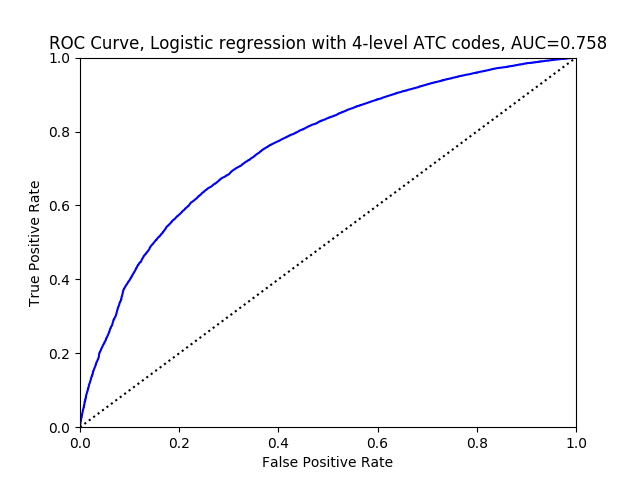

In [156]:
%%python
def compute_roc(clf, Y_test, X_test):
    Y_score = clf.predict_proba(X_test)[:,1].reshape(-1)
    Y_truths = Y_test.reshape(-1)
    fpr, tpr, thresholds = roc_curve(Y_truths, Y_score, pos_label=1)
    return fpr, tpr


fpr, tpr = compute_roc(clf, Y_test, X_test)
roc_auc = auc(fpr, tpr)
print(roc_auc)

plt.clf()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot(fpr, tpr, color="blue")
plt.plot([0,1],[0,1], linestyle=":", color="black")
plt.title("ROC Curve, Logistic regression with 4-level ATC codes, AUC={0:.3f}".format(roc_auc))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.savefig("plots/ml_alg1_auc.pdf")
retval = plotfig_magic()

In [157]:
%%python
fpr_tr, tpr_tr = compute_roc(clf, Y_train, X_train)
roc_auc_tr = auc(fpr_tr, tpr_tr)
print("Logistic regression, AUC on TRAINING set = {0:.5f}".format(roc_auc_tr))
print("Logistic regression, AUC on TEST set = {0:.5f}".format(roc_auc))

print(Y_train.sum()/Y_train.shape[0])
print(Y_test.sum()/Y_test.shape[0])
print(Y_train.shape[0]+Y_test.shape[0])


Logistic regression, AUC on TRAINING set = 0.76099
Logistic regression, AUC on TEST set = 0.75761
0.5001231102575466
0.49975005355995145
212164


### Kun bruke positive diffdager 
* Negative diffdager er før første sykehusinnleggelse i 2013

### Visualisering av modell 
* Heatmap med informasjon hvor ulike modeller testes som måler viktighet av ulike features

## Nye legemidler i den siste perioden før en innleggelse
* Visualisering: nye resepter forskrevet etter en innleggelse
* Noen legemidler som brukes i måneden etter? skjevhet?


# SKLEARN MLP Test

In [ ]:
%%time
%%python
from sklearn.neural_network import MLPClassifier
clf2 = MLPClassifier(solver='adam', alpha=1e-5,
                     activation="logistic",
                     hidden_layer_sizes=(50,), random_state=1)

clf2.fit(X_train.copy(), Y_train.copy())  

nn_fpr_tr, nn_tpr_tr = compute_roc(clf2, Y_train, X_train)
nn_fpr, nn_tpr = compute_roc(clf2, Y_test, X_test)
nn_roc_auc = auc(nn_fpr, nn_tpr)
nn_tr_roc_auc = auc(nn_fpr_tr, nn_tpr_tr)
#print(nn_roc_auc)


0.7709196236142926
0.8223653218164563


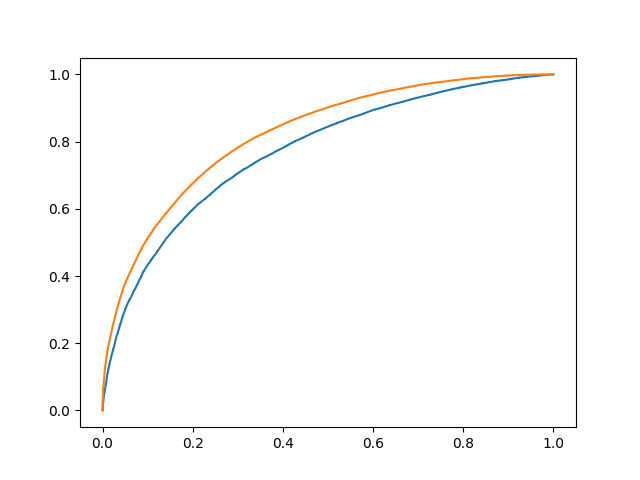

In [168]:
%%python
#out-of-sample AUC
print(nn_roc_auc)
#in-sample AUC
print(nn_tr_roc_auc)
plt.clf()
plt.plot(nn_fpr, nn_tpr)
plt.plot(nn_fpr_tr, nn_tpr_tr)
retval = plotfig_magic()

AUC on TRAIN 0.8445323094566213
AUC on TEST:  0.7540159168552083
Time: 367.3077871799469 seconds.



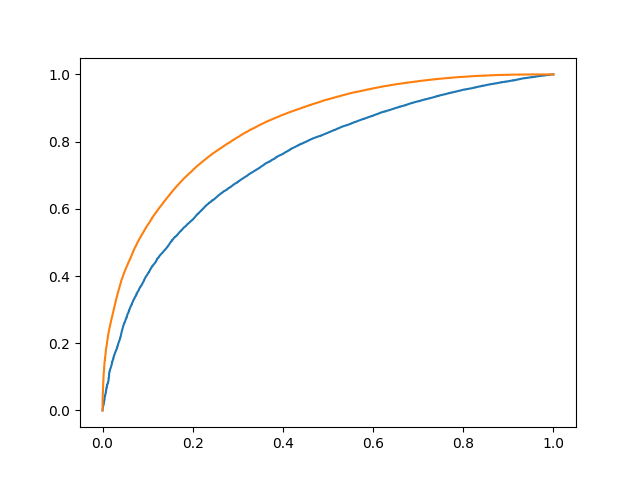

In [169]:
%%time
%%python

def experiment_nn_relu():
    clf2 = MLPClassifier(solver='adam', alpha=1e-5,
                     activation="relu",
                     hidden_layer_sizes=(50,), random_state=1)

    clf2.fit(X_train.copy(), Y_train.copy())  

    nn_fpr_tr, nn_tpr_tr = compute_roc(clf2, Y_train, X_train)
    nn_fpr, nn_tpr = compute_roc(clf2, Y_test, X_test)
    nn_roc_auc = auc(nn_fpr, nn_tpr)
    nn_tr_roc_auc = auc(nn_fpr_tr, nn_tpr_tr)
    
    print("AUC on TRAIN", nn_tr_roc_auc)
    print("AUC on TEST: ",nn_roc_auc)
    plt.clf()
    plt.plot(nn_fpr, nn_tpr)
    plt.plot(nn_fpr_tr, nn_tpr_tr)
    return plotfig_magic()
retval = experiment_nn_relu()

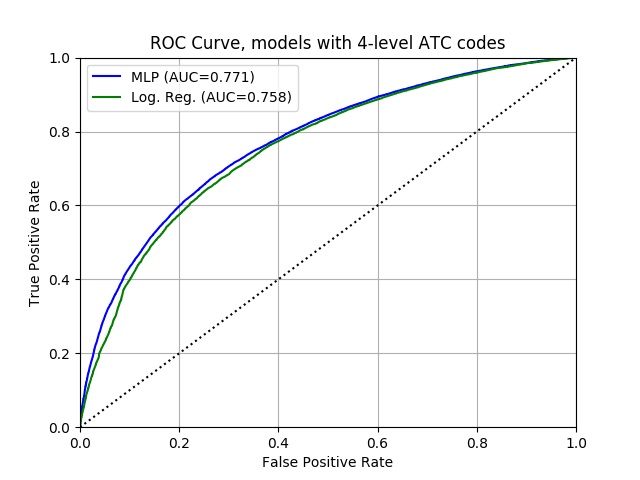

In [170]:
%%python
plt.clf()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid()
plt.plot(nn_fpr, nn_tpr, color="blue")
#plt.plot(nn_fpr_tr, nn_tpr_tr, color="red")
plt.plot(fpr, tpr, color="green")
plt.plot([0,1],[0,1], linestyle=":", color="black")

plt.title("ROC Curve, models with 4-level ATC codes")


plt.legend(["MLP (AUC={0:.3f})".format(nn_roc_auc), "Log. Reg. (AUC={0:.3f})".format(roc_auc)])


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.savefig("plots/ml_alg1_auc.pdf")
retval = plotfig_magic()

# Calibration curve

In [131]:
%%python
from sklearn.calibration import calibration_curve
lr_Y_proba = clf.predict_proba(X_test)[:,1].reshape(-1)
lr_prob_true, lr_prob_pred = calibration_curve(Y_test, Y_proba, n_bins=50)

nn_Y_proba = clf2.predict_proba(X_test)[:,1].reshape(-1)
nn_prob_true, nn_prob_pred = calibration_curve(Y_test, nn_Y_proba, n_bins=50)

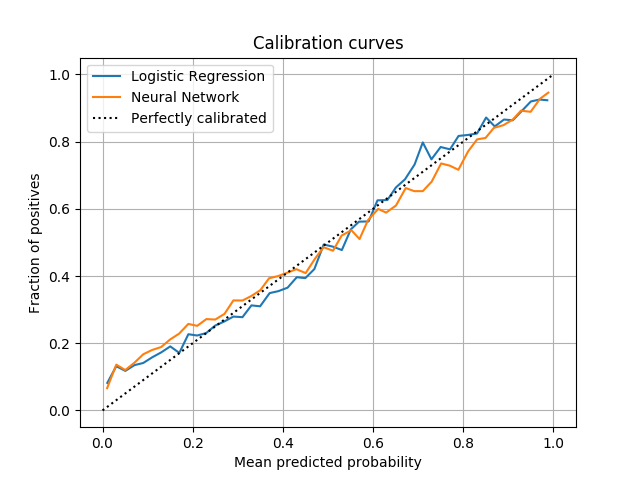

In [172]:
%%python
plt.clf()
plt.plot(lr_prob_pred, lr_prob_true)
plt.plot(nn_prob_pred, nn_prob_true)
plt.plot([0,1],[0,1], linestyle=":", color="black")

plt.title("Calibration curves")
plt.grid()
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.legend(["Logistic Regression",
           "Neural Network",
           "Perfectly calibrated",
           ])
plt.savefig("plots/alg1_calibration_curve.pdf")
retval = plotfig_magic()